# <font style="color:rgb(50,120,229)"> EE5/7382 – Fundamentals of Computer Vision - Homework 5
</font>

##### **<font color="red">Estimating Homographies using RANSAC  (55 points)</font>**
Please read the instructions supplied with the homework for guidance, and deliverables.  

##### <font color="yellow">Preamble</font>

In [1]:
# Preamble
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim   # Measure of Image Similarity

#### <font color="yellow">Helper functions</font>

In [2]:
# Helper functions
def im2double(im):
    info = np.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(float) / info.max # Divide all values by the largest possible value in the datatype


def stitchImagePair(srcImg, dstImg, H_warp):
    [nR,nC,nD] = srcImg.shape
    # Homogeneous Coordinate representation of Source image grid end-points
    A = np.array([0,0,1])           # Top-Left X,Y
    B = np.array([nC-1,0,1])        # Top-Right X,Y
    C = np.array([0,nR-1,1])        # Bottom-Left X,Y
    D = np.array([nC-1,nR-1,1])     # Bottom-Right X,Y

    [nR,nC,nD] = dstImg.shape
    # Homogeneous Coordinate representation of Destination image grid end-points
    I = np.array([0,0,1])           # Top-Left X,Y
    J = np.array([nC-1,0,1])        # Top-Right X,Y
    K = np.array([0,nR-1,1])        # Bottom-Left X,Y
    L = np.array([nC-1,nR-1,1])     # Bottom-Right X,Y

    # Map the 4 corner's of the source Image grid to the destination image grid using the homography
    Apr = np.matmul(H_warp,A)   # X', Y', 1
    Apr = Apr/Apr[2]
    Bpr = np.matmul(H_warp,B)   # X', Y', 1
    Bpr = Bpr/Bpr[2]
    Cpr = np.matmul(H_warp,C)   # X', Y', 1
    Cpr = Cpr/Cpr[2]
    Dpr = np.matmul(H_warp,D)   # X', Y', 1
    Dpr = Dpr/Dpr[2]

    # Extract the col coordinates from A,B,C,D  
    cc = np.array([I[0],J[0],K[0],L[0]])                # X coordinate
    rr = np.array([I[1],J[1],K[1],L[1]])                # Y coordinate
    cc_prime = np.array([Apr[0],Bpr[0],Cpr[0],Dpr[0]])  # X' coordinate
    rr_prime = np.array([Apr[1],Bpr[1],Cpr[1],Dpr[1]])  # Y' coordinate

    # Bounding Box of panorama that accommodates warped source grid & destination grid 
    min_row = np.min([ I[1],J[1], Apr[1],Bpr[1] ])     # TL, TR
    min_col = np.min([ I[0],K[0], Apr[0],Cpr[0] ])     # TL, BL
    max_row = np.max([ K[1],L[1], Cpr[1],Dpr[1] ])     # BL, BR
    max_col = np.max([ J[0],L[0], Bpr[0],Dpr[0] ])     # TR, BR
    
    # The panorama spans A:(min_row,min_col) 
    # Purely for debugging purposes   
    # plt.figure()
    # plt.plot(cc,rr,'r.', label="Source")
    # plt.plot(cc_prime,rr_prime,'b.', label='Destination')
    # plt.plot(min_col,min_row,'m+',min_col,max_row,'m+',max_col,min_row,'m+',max_col,max_row,'m+')
    # plt.legend(loc='best')
    # plt.gca().invert_yaxis()
    # plt.show()

    # ------------------------------------------------------------------------------------------------
    # Calculate size of panorama
    # The dimensions of the warped source image are given by (max_row-min_row) x (max_col-min_col)
    # The panorama must be large enough to accommodate the warped source image & the destination image
    # ------------------------------------------------------------------------------------------------
    pan_height = int(max_row - min_row)      # Height of Panorama
    pan_width = int(max_col - min_col)       # Width of Panorama

    pan = np.zeros([pan_height,pan_width], dtype=np.float32)
    # print('Panorama Size: {}'.format(pan.shape))

    # Calculate offset between the top-left corner of the destination image grid 
    # and the top-left corner of the panorama grid
    row_offset = -min_row
    col_offset = -min_col
    # Q): Why is this a model for translation? HINT: Identify the relation between [x', y', 1] & [x, y, 1] for H_translation 
    # Include an illustration of motion models
    H_translate = np.eye(3)
    H_translate[1,2] = row_offset
    H_translate[0,2] = col_offset   
    
    # ----------------------------------------------------    
    # Embed source & destination images into panorama grid
    # ----------------------------------------------------    
    # Warp followed by Translation H_translate * H_warp * [x ; y ; 1]
    warped_src = cv.warpPerspective(srcImg, np.matmul(H_translate, H_warp), (pan_width, pan_height))
    
    # Translate destination image into panorama image grid
    warped_dst = cv.warpPerspective(dstImg, H_translate, (pan_width, pan_height))

    # --------------
    # Alpha blending
    # --------------
    # Q) What is being accomplished here?
    alpha = 0.5
    panImg = (alpha)*np.float64(warped_src) + (1-alpha)*np.float64(warped_dst) 
    panImg = np.uint8(panImg)

    return panImg

#### <font color="yellow">Step1-: Read the images using `imread()`</font>

In [3]:
fileName = ('keble_a.jpg','keble_b.jpg')
dirPath = './'

# Read in Color mode
srcImg_Color = cv.imread( dirPath + fileName[0] )   # keble_a.jpg
dstImg_Color = cv.imread( dirPath + fileName[1] )   # keble_b.jpg

# Convert to Grayscale                         
srcImg = cv.cvtColor(srcImg_Color, cv.COLOR_BGR2GRAY)       
dstImg = cv.cvtColor(dstImg_Color, cv.COLOR_BGR2GRAY)       

#### <font color="yellow">Step-3: Find keypoints</font>
<font color="cyan"><b>Useful SIFT functions:</b></font> `SIFT_create()`,`detectAndCompute()`,`compute()`<br>
Lookup https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html for additional help

In [4]:
queryImg = srcImg       # Source Image is query image which will be matched to training image
trainImg = dstImg       # Destination Image is training image

# Initialize SIFT
siftObj = cv.SIFT_create()

# Find SIFT descriptors in training image
[kpT, desT] = siftObj.detectAndCompute(trainImg,None)    
print('Number of keypoints in Destination/Training image ' + str(len(kpT)))

# Find SIFT keypoints in query image
[kpQ, desQ] = siftObj.detectAndCompute(queryImg,None)
print('Number of keypoints in Source/Query image ' + str(len(kpQ)))

Number of keypoints in Destination/Training image 4188
Number of keypoints in Source/Query image 4054


#### <font color="yellow">Step-4: Match keypoints</font>
<font color="cyan"><b>Useful functions for matching correspondences:</b></font> `BFMatcher()`,`match()`<br>
Lookup https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html for additional help
<p>

The result of `matches = bf.match(des1,des2)` is a <b>list</b> of OpenCV `DMatch` objects.<br> 
Each instance of DMatch has the following attributes:
* `DMatch.distance` - Distance between descriptors. The lower, the better it is.
* `DMatch.trainIdx` - Index of the descriptor in train descriptors
* `DMatch.queryIdx` - Index of the descriptor in query descriptors
* `DMatch.imgIdx` - Index of the train image.

The `queryIdx` corresponds to points in the source image and `trainIdx` corresponds to points in the destination image.
 
<b>Reference Material:</b> https://docs.opencv.org/3.4/db/d39/classcv_1_1DescriptorMatcher.html#a0f046f47b68ec7074391e1e85c750cba


Text(0.5, 1.0, 'Top 20 Correspondences (Source, Destination)')

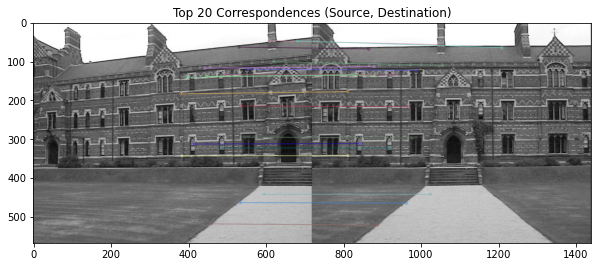

In [9]:

# Feature matching using BFMatcher
bf = cv.BFMatcher()
# Match descriptors using match()

matches = bf.match(desQ,desT)
# Sort them in the increasing order of distance using sorted()
matches = sorted(matches, key = lambda x:x.distance)

# Visualize top 20 matches - Use this to verify your implementation
imMatches = cv.drawMatches(srcImg,kpQ, dstImg,kpT, matches[0:20],None,flags=2)
plt.figure(figsize=[10,10])
plt.imshow(imMatches)
plt.title("Top 20 Correspondences (Source, Destination)")

#### <font color="yellow">Step-5: Identify pixel coordinates of matching correspondences in the two views</font>

In [11]:
numCorrespondences = len(matches)

# Allocate storage for (x,y) coordinates of keypoints in the source image
src_pts = np.zeros([numCorrespondences,2], dtype=np.float32)  
# Allocate storage for (x',y') coordinates of keypoints in the destination image
dst_pts = np.zeros([numCorrespondences,2], dtype=np.float32)  

# Populate each row of src_pts & dst_pts
for nn, match in enumerate(matches):
    src_pts[nn, :] = kpQ[match.queryIdx].pt     # Pts in image-1
    dst_pts[nn, :] = kpT[match.trainIdx].pt     # Pts in image-2

#### <font color="yellow">Step-6: </font>
* Select a set $C$ of correspondences $\{\mathbf{x}_i,\mathbf{x}^{'}_{i}\}_{i=1}^{N}$
* Compute homography $H$ from Source Image to Destination Image using the set of correspondences $C$
* Assemble Panorama using homography $H$ using RANSAC
* Visualize result, and make inference
<br><br>
<b>Reference Material</b>
* https://towardsdatascience.com/image-panorama-stitching-with-opencv-2402bde6b46c
* https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

Homograhy from source image to destination image 
[[ 1.23833049e+00 -2.68327479e-02 -3.63054381e+02]
 [ 1.25295660e-01  1.16890376e+00 -6.29826493e+01]
 [ 3.27211183e-04  3.81896345e-06  1.00000000e+00]]


(<matplotlib.image.AxesImage at 0x24502ce8fd0>,
 Text(0.5, 1.0, 'Best Panorama'))

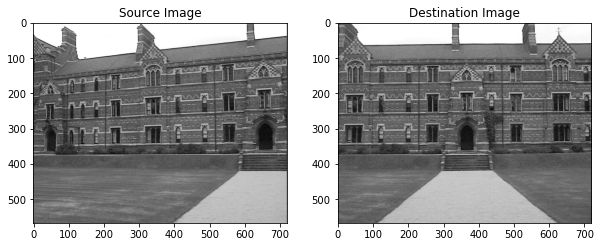

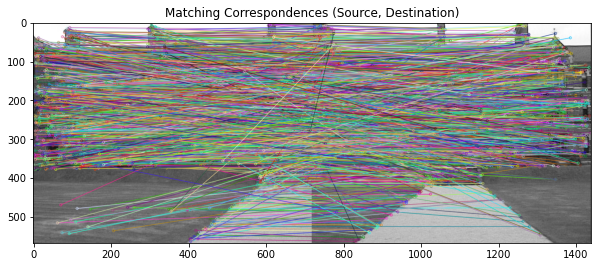

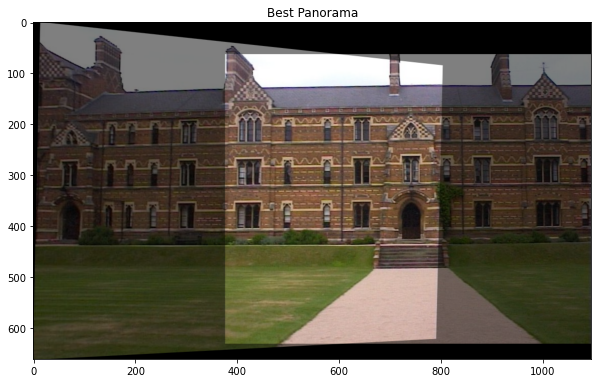

In [12]:
startIdx = 0
endIdx = numCorrespondences
RANSAC_reProjErr = 2.0

# --------------------
# Solve for homography
# --------------------
[H_f, mask] = cv.findHomography( src_pts[startIdx:endIdx,:], dst_pts[startIdx:endIdx,:], cv.RANSAC, RANSAC_reProjErr )
print('Homograhy from source image to destination image \n{}'.format(H_f))  # Print estimated homography    

# -----------------
# Assemble Panorama
# -----------------
best_panorama = stitchImagePair(srcImg_Color, dstImg_Color, H_f)

# -----------------
# Visualize Results 
# -----------------
# Display source & destination images
plt.figure(figsize=(10,10))
plt.subplot(121),   plt.imshow(srcImg,cmap='gray'), plt.title('Source Image')
plt.subplot(122),   plt.imshow(dstImg,cmap='gray'), plt.title('Destination Image')

# Display the correspondences used to estimate the homography
# Q) What is flags=2 trying to accomplish?
# https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html
imMatches = cv.drawMatches(srcImg,kpQ, dstImg,kpT, matches[startIdx:endIdx], None,flags=2)
plt.figure(figsize=[10,10])
plt.imshow(imMatches), plt.title('Matching Correspondences (Source, Destination)')

# Display panorama
plt.figure(figsize=(10,10))
plt.imshow( cv.cvtColor(best_panorama, cv.COLOR_BGR2RGB) ), plt.title('Best Panorama')

#### <font color="yellow">Step-7: Repeat Step-6 for different choice of parameters</font>

Homograhy from source image to destination image 
[[ 1.28053934e+00 -2.45073029e-02 -3.76184912e+02]
 [ 1.34577805e-01  1.22216306e+00 -6.98649253e+01]
 [ 3.75549647e-04  8.62776248e-05  1.00000000e+00]]
SSIM: 0.5130190907226423


(<matplotlib.image.AxesImage at 0x245084faaf0>, Text(0.5, 1.0, 'Panorama'))

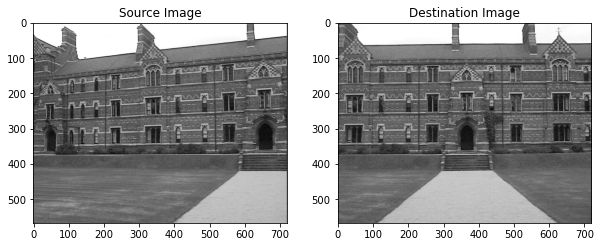

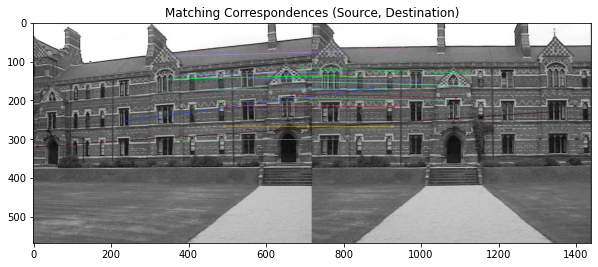

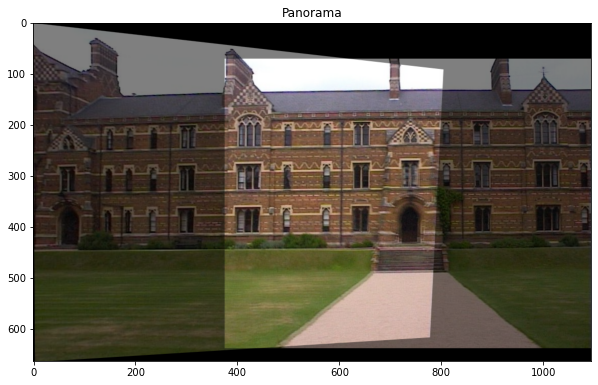

In [36]:
startIdx = 200
numKeep =  20
endIdx = startIdx + numKeep
RANSAC_reProjErr =5

# --------------------
# Solve for homography
# --------------------
[H_f, mask] = cv.findHomography( src_pts[startIdx:endIdx,:], dst_pts[startIdx:endIdx,:], cv.RANSAC, RANSAC_reProjErr )
print('Homograhy from source image to destination image \n{}'.format(H_f))  # Print estimated homography    

# -----------------
# Assemble Panorama
# -----------------
new_panorama = stitchImagePair(srcImg_Color, dstImg_Color, H_f)

# Compute SSIM between reference panorama and estimated panorama
# https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html
# SSIM is bounded between 0 & 1, larger is better
resized_panorama = cv.resize(new_panorama,[best_panorama.shape[1],best_panorama.shape[0]])
score = ssim( 
                cv.cvtColor(best_panorama,cv.COLOR_BGR2GRAY), 
                cv.cvtColor(resized_panorama,cv.COLOR_BGR2GRAY) 
            )
print("SSIM: {}".format(score))

# -----------------
# Visualize Results 
# -----------------
# Display source & destination images
plt.figure(figsize=(10,10))
plt.subplot(121),   plt.imshow(srcImg,cmap='gray'), plt.title('Source Image')
plt.subplot(122),   plt.imshow(dstImg,cmap='gray'), plt.title('Destination Image')

# Display correspondences
# Q) What is flags=2 trying to accomplish?
# https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html
imMatches = cv.drawMatches(srcImg,kpQ, dstImg,kpT, matches[startIdx:endIdx], None,flags=2)
plt.figure(figsize=[10,10])
plt.imshow(imMatches), plt.title('Matching Correspondences (Source, Destination)')

# Display panorama
plt.figure(figsize=(10,10))
plt.imshow( cv.cvtColor(new_panorama, cv.COLOR_BGR2RGB) ), plt.title('Panorama')